In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Auxillary function declarations 

In [2]:
# --- flux components ---
def h_xxx(h, dx):
    """Compute third derivative using forward differences (periodic)."""
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)
    h_b2 = np.roll(h, 2)
    return (h_f1 - 3*h + 3*h_b1 - h_b2) / dx**3 

def f(h, eps):
    return h**4 / (eps + h**3.5)

def a_gs(s1, s2, eps):
    return f(0.5*(s1 + s2), eps)

def da_gs(s1, s2, eps):
    s = s1 + s2
    return 0.5 * s**3 * (4*eps + 0.5*s**3.5) / (eps + s**3.5)**2


def a_eds(s1, s2, eps):
    N = s1.shape[0]
    a = np.empty(N)
    for i in range(N):
        if s1[i] == s2[i]:
            a[i] = f(s1)
        else:
            Gp1 = 2 * np.sqrt(s1[i]) - eps / (3 * s1[i]**3)
            Gp2 = 2 * np.sqrt(s2[i]) - eps / (3 * s2[i]**3)
            a[i] = (s1[i] - s2[i]) / (Gp1 - Gp2)
    
    return a

# --- Diff schemes ---
def GS(h, h_curr, dx, dt, eps):
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)
    f_f12 = a_gs(h, h_f1, eps) * h_xxx(h_f1, dx)
    f_b12 = a_gs(h_b1, h, eps) * h_xxx(h, dx)
    return h - h_curr + (dt/dx) * (f_f12 - f_b12)


def EDS(h, h_curr, dx, dt, eps):
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)
    f_f12 = a_eds(h, h_f1, eps) * h_xxx(h_f1, dx)
    f_b12 = a_eds(h_b1, h, eps) * h_xxx(h, dx)
    return h - h_curr + (dt/dx) * (f_f12 - f_b12)


# --- Jacobian ---
def DGS(h, h_curr, dx, dt, eps):
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)

    F_hb2 = (dt/dx) * a_gs(h_b1, h, eps) / dx**3
    F_hb1 = (dt/dx) * (a_gs(h, h_f1, eps)/dx**3 - da_gs(h_b1, h, eps) * h_xxx(h, dx) + 3*a_gs(h_b1, h, eps)/dx**3)
    F_h = 1 + (dt/dx) * (da_gs(h, h_f1, eps)*h_xxx(h_f1, dx) + 3*a_gs(h, h_f1, eps)/dx**3 - da_gs(h_b1,h, eps)*h_xxx(h, dx) + 3*a_gs(h_b1,h, eps)/dx**3)
    F_hf1 = (dt/dx) * (da_gs(h,h_f1, eps)*h_xxx(h_f1, dx) - 3*a_gs(h,h_f1, eps)/dx**3 - a_gs(h_b1,h, eps)/dx**3)
    F_hf2 = (dt/dx) * a_gs(h,h_f1, eps)/dx**3

    # Initialize Jacobian
    G = np.zeros((h_curr.shape[0], h_curr.shape[0]))

    # Fill stencil with modulo indexing for periodicity
    for i in range(h_curr.shape[0]):
        G[i, i] = F_h[i]
        G[i, (i-1)%N] = F_hb1[i]
        G[i, (i-2)%N] = F_hb2[i]
        G[i, (i+1)%N] = F_hf1[i]
        G[i, (i+2)%N] = F_hf2[i]

    return G

## Fine grid simulations 

### Solution evolution using the generic scheme with large $\Delta t$

In [3]:
N = 512
dx = 1/N
dt = 1e-6
eps = 1e-7

x = np.linspace(-1, 1, N, endpoint=False)
K = 50000
h0 = 0.8 - np.cos(np.pi*x) + 0.25 * np.cos(2 * np.pi * x)

sampling_iters = [999, 1999, 4999, 7999, 15999, 31999, 49999]
sampled_sol = []

h_curr = h0

for k in range(K):
    if k == 50000:
        dt = 1e-4
    #print("Iter", k)
    if  k % 1000 == 0:
        print("Iter", k)
    sol = scipy.optimize.root(GS, h_curr, args=(h_curr, dx, dt, eps))
    if sol.success:
        h_curr = sol.x
    else:
        print("Trying a spectral residual method")
        sol = scipy.optimize.root(GS, h_curr, args=(h_curr, dx, dt, eps), method="df-sane")
        if sol.success:
            h_curr = sol.x
        else:
            print(f"Still cannot resolve the instability at Iter {k}")
            break

    if k in sampling_iters:
        sampled_sol.append(h_curr)

Iter 0
Iter 1000
Iter 2000
Iter 3000
Iter 4000
Iter 5000
Iter 6000
Iter 7000
Iter 8000
Iter 9000
Iter 10000
Iter 11000
Iter 12000
Iter 13000
Iter 14000
Iter 15000
Iter 16000
Iter 17000
Iter 18000
Iter 19000
Iter 20000
Iter 21000
Iter 22000
Iter 23000
Iter 24000
Iter 25000
Iter 26000
Iter 27000
Iter 28000
Iter 29000
Iter 30000
Iter 31000
Iter 32000
Iter 33000
Iter 34000
Iter 35000
Iter 36000
Iter 37000
Iter 38000
Iter 39000
Iter 40000
Iter 41000
Iter 42000
Iter 43000
Iter 44000
Iter 45000
Iter 46000
Iter 47000
Iter 48000
Iter 49000


In [ ]:
plt.plot(x, h_curr)

<>:9: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:9: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
/var/folders/pb/4lxjhwzj7gjbp6jx2bhl7fwc0000gn/T/ipykernel_15645/2299957692.py:9: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  plt.ylabel("$h_\epsilon(x, t), \ \epsilon=10^{-7}$")


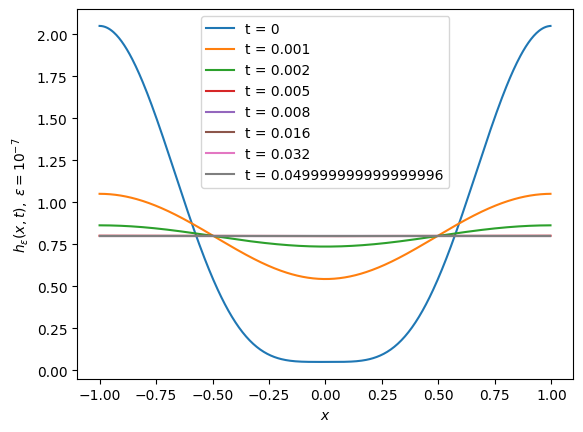

In [8]:
plt.figure()
plt.plot(x, h0, label="t = 0")

for i in range(len(sampled_sol)):
    t = (sampling_iters[i] + 1) * 1e-6
    plt.plot(x, sampled_sol[i], label=f"t = {t}")

plt.xlabel("$x$")
plt.ylabel("$h_\epsilon(x, t), \ \epsilon=10^{-7}$")
plt.legend()
plt.savefig("sim_results.png", dpi = 200)

In [ ]:
N = 128
dx = 1/N
dt = 1e-5
eps = 1e-7

x = np.linspace(-1, 1, N, endpoint=False)
K = 5460
h0 = 0.8 - np.cos(np.pi*x) + 0.25 * np.cos(2 * np.pi * x)

sampling_iters = [999, 1999, 4999, 5039, 5119, 5279, 5460]
sampled_sol = []

h_curr = h0

for k in range(100):
    if k == 5000:
        dt = 1e-4
    #print("Iter", k)
    #if  k % 100 == 0:
    #    print("Iter", k)
    sol = scipy.optimize.root(EDS, h_curr, args=(h_curr, dx, dt, eps))
    if sol.success:
        h_curr = sol.x
    else:
        print("Trying a spectral residual method")
        sol = scipy.optimize.root(EDS, h_curr, args=(h_curr, dx, dt, eps), method="df-sane")
        if sol.success:
            h_curr = sol.x
        else:
            print(f"Still cannot resolve the instability at Iter {k}")
            break

    if k in sampling_iters:
        sampled_sol.append(h_curr)

In [ ]:
plt.plot(x, h_curr)